# 공공데이터를 활용한 미세먼지 농도 예측 프로젝트
## 단계2. 모델링(머신러닝)

## 0.프로젝트 소개

### (1) 수행 목표
- 미세먼지 농도를 예측하는 머신러닝 모델을 만드세요.

#### 우리가 풀어야 하는 문제는 무엇인가요?
* 서울 지역의 미세먼지 데이터와 날씨 데이터를 활용하여,
미세먼지 예측에 관련 있는 데이터 항목으로 데이터를 구성, 전처리 하여
미세먼지 농도를 예측하는 머신러닝 모델 구현


### (2) 데이터 소개

#### 1) 기본 데이터

* 학습 데이터
    * air_2021.csv : 2021년 미세먼지 데이터
    * weather_2021.csv : 2021년 날씨 데이터
* 테스트 데이터
    * air_2022.csv : 2022년 미세먼지 데이터
    * weather_2022.csv : 2022년 날씨 데이터

#### 2) 데이터셋의 변수 소개(weather_2021)

* 증기압: 증기가 고체 또는 액체와 동적 평형 상태에 있을 때 증기의 압력 (증기가 되려는 힘)
* 이슬점 온도: 불포화 상태의 공기가 냉각될 때, 포화 상태에 도달하여 수증기의 응결이 시작되는 온도
* 일조: 일정한 물체나 땅의 겉면에 태양 광선이 비치는 시간 (1시간 중 비율)
* 일사(량): 태양으로부터 오는 태양 복사 에너지가 지표에 닿는 양 (면적당 에너지 량)
* 전운량: 하늘을 육안으로 관측하여 전부 구름일 때 10, 구름이 덮고 있는 하늘의 비율에 따라 0~10
* 중하층운량: 중층과 하층에 있는 구름의 분포량(중하층 구름이 날씨에 영향 주므로 따로 표기)
* 운형(운형약어): 구름의 종류. 약어 코드로 기재됨
* 최저운고: 가장 낮은 구름의 높이
* 현상번호(국내식): 비, 소낙비, 싸락눈, 눈보라 등의 기상현상을 나타낸 코드번호
* 지면온도: 지면 0cm 온도
* 지중온도: 땅 속 온도변수1

#### 2) 라이브러리 로딩

In [3]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pycaret.regression import *

from sklearn.ensemble import StackingRegressor
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# MicroDust Predictor class

In [4]:
class FineDustPredictor:
    def __init__(self, train_x_path, train_y_path, test_x_path, test_y_path):
        self.train_x = pd.read_csv(train_x_path)
        self.train_y = pd.read_csv(train_y_path)
        self.test_x = pd.read_csv(test_x_path)
        self.test_y = pd.read_csv(test_y_path)
        # self.scaler = StandardScaler()
        self.scaler = MinMaxScaler()
        self.tuned_models = []
        self.results = {}
        self.pre_tuning_results = {}

    def normalize_data(self):
        """Normalize the training and testing datasets."""
        self.train_x = pd.DataFrame(self.scaler.fit_transform(self.train_x), columns=self.train_x.columns)
        self.test_x = pd.DataFrame(self.scaler.transform(self.test_x), columns=self.test_x.columns)

    def setup_autoML(self):
        """Set up PyCaret for AutoML and compare models."""
        self.data = pd.concat([self.train_x, self.train_y], axis=1)
        setup(data=self.data, target=self.train_y.columns[0], session_id=42, use_gpu=True)

    def compare_models(self):
        """Compare models based on R2 score and return top 5 models."""
        self.best_models = compare_models(sort='R2', n_select=5)
        return self.best_models

    def evaluate_models(self, models, results_dict):
        """Evaluate the given models on the test dataset and store results."""
        for model in models:
            # Make predictions
            predictions = predict_model(model, data=self.test_x)
            # print(predictions.columns)

            # Use the 'Label' column for predicted values
            pred = predictions['prediction_label']

            # Calculate performance metrics using test_y['PM10_1'] for actual values
            r2 = r2_score(self.test_y['PM10_1'], pred)
            mse = mean_squared_error(self.test_y['PM10_1'], pred)
            model_name = str(model).split('(')[0]  # Extract model name
            results_dict[model_name] = {'R2 Score': r2, 'MSE': mse}

    def stack_models(self):
        """Stack tuned models and evaluate performance."""
        # Prepare base model predictions
        X_meta = []
        y_meta = self.train_y['PM10_1']

        for model in self.tuned_models:
            train_predictions = predict_model(model, data=self.train_x)['prediction_label']
            X_meta.append(train_predictions)

        X_meta = np.array(X_meta).T

        # Split into training and validation sets for stacking
        X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(X_meta, y_meta, test_size=0.2, random_state=42)

        # Define the stacking model
        stacker = StackingRegressor(
            estimators=[(str(model).split('(')[0], model) for model in self.tuned_models],
            final_estimator=LinearRegression(),
            cv=5
        )

        # Train the stacking model
        stacker.fit(X_train_meta, y_train_meta)

        # Make predictions
        predictions = stacker.predict(X_val_meta)

        # Evaluate the stacking model
        r2 = r2_score(y_val_meta, predictions)
        mse = mean_squared_error(y_val_meta, predictions)

        # Store the stacking results
        self.results['Stacked Model'] = {'R2 Score': r2, 'MSE': mse}
        print(f'Stacked Model - R2 Score: {r2:.4f}, MSE: {mse:.4f}')

    def tune_and_save_models(self):
        """Tune hyperparameters for each of the top models and save them."""
        for model in self.best_models:
            # Save performance metrics before tuning
            self.pre_tuning_results[str(model).split('(')[0]] = {}

            # Evaluate model before tuning
            self.evaluate_models([model], self.pre_tuning_results)

            tuned_model = tune_model(model, optimize='R2')
            self.tuned_models.append(tuned_model)

            # Save original model
            model_name = str(model).split('(')[0]  # Extract model name
            with open(f'./models/model_{model_name}.pkl', 'wb') as f:
                pickle.dump(model, f)

            # Save tuned model
            with open(f'./models/tuned_model_{model_name}.pkl', 'wb') as f:
                pickle.dump(tuned_model, f)

            # Evaluate tuned model
            self.evaluate_models([tuned_model], self.results)

        # Call the stacking method after tuning models
        self.stack_models()

    def display_results(self):
        """Display the evaluation results of the models in a formatted way and visualize them."""
        # Prepare data for visualization
        pre_tuning_df = pd.DataFrame.from_dict(self.pre_tuning_results, orient='index').reset_index()
        pre_tuning_df.rename(columns={'index': 'Model Name'}, inplace=True)
        pre_tuning_df['Stage'] = 'Before Tuning'

        post_tuning_df = pd.DataFrame.from_dict(self.results, orient='index').reset_index()
        post_tuning_df.rename(columns={'index': 'Model Name'}, inplace=True)
        post_tuning_df['Stage'] = 'After Tuning'

        # Combine dataframes for visualization
        comparison_df = pd.concat([pre_tuning_df, post_tuning_df], ignore_index=True)

        # Set up the matplotlib figure with larger size and style
        plt.figure(figsize=(16, 8))
        sns.set_style("whitegrid")

        # Create bar plots for R2 Score
        plt.subplot(1, 2, 1)
        r2_plot = sns.barplot(data=comparison_df, x='Model Name', y='R2 Score', hue='Stage', palette='Set2')
        plt.title('R2 Score Comparison', fontsize=16)
        plt.xticks(rotation=45)
        plt.ylabel('R2 Score', fontsize=14)
        plt.xlabel('Model Name', fontsize=14)
        for p in r2_plot.patches:
            r2_plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=12)

        # Create bar plots for MSE
        plt.subplot(1, 2, 2)
        mse_plot = sns.barplot(data=comparison_df, x='Model Name', y='MSE', hue='Stage', palette='Set2')
        plt.title('MSE Comparison', fontsize=16)
        plt.xticks(rotation=45)
        plt.ylabel('Mean Squared Error', fontsize=14)
        plt.xlabel('Model Name', fontsize=14)
        for p in mse_plot.patches:
            mse_plot.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='bottom', fontsize=12)

        plt.tight_layout()
        plt.show()

        # Print results in text format with improved formatting
        print("\nModel Evaluation Results Before Tuning:")
        print(f"{'Model Name':<30} {'R2 Score':<15} {'MSE':<15}")
        print("-" * 60)
        for model_name, metrics in self.pre_tuning_results.items():
            print(f"{model_name:<30} {metrics['R2 Score']:<15.4f} {metrics['MSE']:<15.4f}")

        print("\nModel Evaluation Results After Tuning:")
        print(f"{'Model Name':<30} {'R2 Score':<15} {'MSE':<15}")
        print("-" * 60)
        for model_name, metrics in self.results.items():
            print(f"{model_name:<30} {metrics['R2 Score']:<15.4f} {metrics['MSE']:<15.4f}")


# [Step 3] 머신러닝 모델링 1

#### **<span style="color:blue">[3-1] 학습 및 테스트 데이터 로딩</span>**

In [5]:
predictor = FineDustPredictor(
    train_x_path='./data/train_x.csv',
    train_y_path='./data/train_y.csv',
    test_x_path='./data/test_x.csv',
    test_y_path='./data/test_y.csv'
)

In [6]:

predictor.normalize_data()

---

#### **<span style="color:blue">[3-2] 모델링 </span>**

# [Step 4, 5, 6] AutoML을 통한 머신러닝 모델링 및 상위 3개 모델에 대한 Hyperparameter tuning

In [7]:
predictor.setup_autoML()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

,Description,Value
0,Session id,42
1,Target,PM10_1
2,Target type,Regression
3,Original data shape,"(8432, 27)"
4,Transformed data shape,"(8432, 27)"
5,Transformed train set shape,"(5902, 27)"
6,Transformed test set shape,"(2530, 27)"
7,Numeric features,26
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

In [8]:
best_models = predictor.compare_models()
print("Top 5 Models based on R2 Score:")
print(best_models)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.1032,75.8464,8.3236,0.9662,0.1665,0.1294,0.5860
gbr,Gradient Boosting Regressor,4.0083,79.5549,8.4572,0.9658,0.1651,0.1290,1.7840
br,Bayesian Ridge,4.0283,75.6301,8.4715,0.9654,0.1667,0.1258,0.1680
lr,Linear Regression,4.0300,75.6520,8.4725,0.9654,0.1667,0.1259,0.0890
rf,Random Forest Regressor,4.1030,80.9684,8.5452,0.9647,0.1644,0.1274,1.2160
par,Passive Aggressive Regressor,4.6870,81.6297,8.8511,0.9626,0.2334,0.1646,0.0760
huber,Huber Regressor,4.4097,81.6185,8.8803,0.9618,0.1948,0.1515,0.2450
ridge,Ridge Regression,4.3281,88.2324,9.2507,0.9596,0.1858,0.1467,0.0630
xgboost,Extreme Gradient Boosting,4.1550,95.1974,9.2780,0.9569,0.1748,0.1309,0.3360
lightgbm,Light Gradient Boosting Machine,4.2485,131.4488,10.9302,0.9427,0.1690,0.1270,0.1730


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Top 5 Models based on R2 Score:
[ExtraTreesRegressor(n_jobs=-1, random_state=42), GradientBoostingRegressor(random_state=42), BayesianRidge(), LinearRegression(n_jobs=-1), RandomForestRegressor(n_jobs=-1, random_state=42)]


## 학습한 모델을 파일로 저장

In [9]:
predictor.tune_and_save_models()

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.2519,86.3611,9.2931,0.9635,0.3334,0.3206
1,5.9850,125.5489,11.2049,0.9342,0.2823,0.2607
2,6.0640,94.6008,9.7263,0.9566,0.3189,0.3024
3,6.2256,116.5290,10.7949,0.9539,0.3058,0.2873
4,6.0564,79.1104,8.8944,0.9745,0.3492,0.3432
5,6.3727,177.8628,13.3365,0.9414,0.3242,0.3011
6,5.5587,67.4713,8.2141,0.9213,0.3237,0.3122
7,5.8853,75.7819,8.7053,0.9663,0.2899,0.2652
8,6.7710,175.9321,13.2639,0.9316,0.2937,0.2737


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.4084,63.6829,7.9802,0.9731,0.1927,0.1555
1,4.6707,133.2675,11.5442,0.9301,0.1821,0.1450
2,4.2318,71.4521,8.4529,0.9672,0.1936,0.1482
3,4.3520,53.0377,7.2827,0.9790,0.1974,0.1581
4,4.4563,67.9313,8.2420,0.9781,0.2032,0.1615
5,4.6480,147.1386,12.1301,0.9515,0.1999,0.1533
6,3.9199,45.0256,6.7101,0.9475,0.1967,0.1510
7,4.4959,59.2948,7.7003,0.9736,0.1910,0.1482
8,5.1475,128.3961,11.3312,0.9501,0.2325,0.1689


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8977,44.2975,6.6556,0.9813,0.1708,0.1295
1,4.2768,106.0720,10.2991,0.9444,0.1638,0.1218
2,3.8567,46.6604,6.8308,0.9786,0.1650,0.1270
3,3.7451,39.6236,6.2947,0.9843,0.1512,0.1190
4,4.1251,76.9393,8.7715,0.9752,0.1780,0.1358
5,4.1118,99.1609,9.9580,0.9673,0.1654,0.1225
6,3.5353,47.0630,6.8602,0.9451,0.1622,0.1226
7,4.0807,49.2343,7.0167,0.9781,0.1761,0.1305
8,4.7613,157.4193,12.5467,0.9388,0.1824,0.1339


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8972,44.2791,6.6543,0.9813,0.1709,0.1295
1,4.2791,106.1634,10.3036,0.9443,0.1640,0.1219
2,3.8557,46.6212,6.8280,0.9786,0.1651,0.1270
3,3.7439,39.5747,6.2908,0.9843,0.1511,0.1189
4,4.1266,77.0472,8.7777,0.9752,0.1780,0.1358
5,4.1111,99.1179,9.9558,0.9673,0.1654,0.1225
6,3.5359,47.0579,6.8599,0.9451,0.1623,0.1226
7,4.0804,49.2248,7.0160,0.9781,0.1761,0.1305
8,4.7613,157.4841,12.5493,0.9388,0.1823,0.1339


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 2 candidates, totalling 20 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.1167,48.1293,6.9375,0.9797,0.1885,0.1531
1,4.4326,110.6658,10.5198,0.9420,0.1823,0.1436
2,4.0927,59.7381,7.7290,0.9726,0.1868,0.1483
3,4.1048,76.5673,8.7503,0.9697,0.1827,0.1469
4,4.2026,52.7881,7.2655,0.9830,0.2067,0.1684
5,4.5130,123.2035,11.0997,0.9594,0.1957,0.1519
6,3.6572,30.5563,5.5278,0.9644,0.1960,0.1553
7,4.3904,58.5472,7.6516,0.9740,0.1954,0.1528
8,5.4401,246.9967,15.7161,0.9040,0.1961,0.1541


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Stacked Model - R2 Score: 0.9451, MSE: 127.2147


In [10]:
predictor.stack_models()

Stacked Model - R2 Score: 0.9451, MSE: 127.2147


## Test 데이터로 성능을 평가한 결과

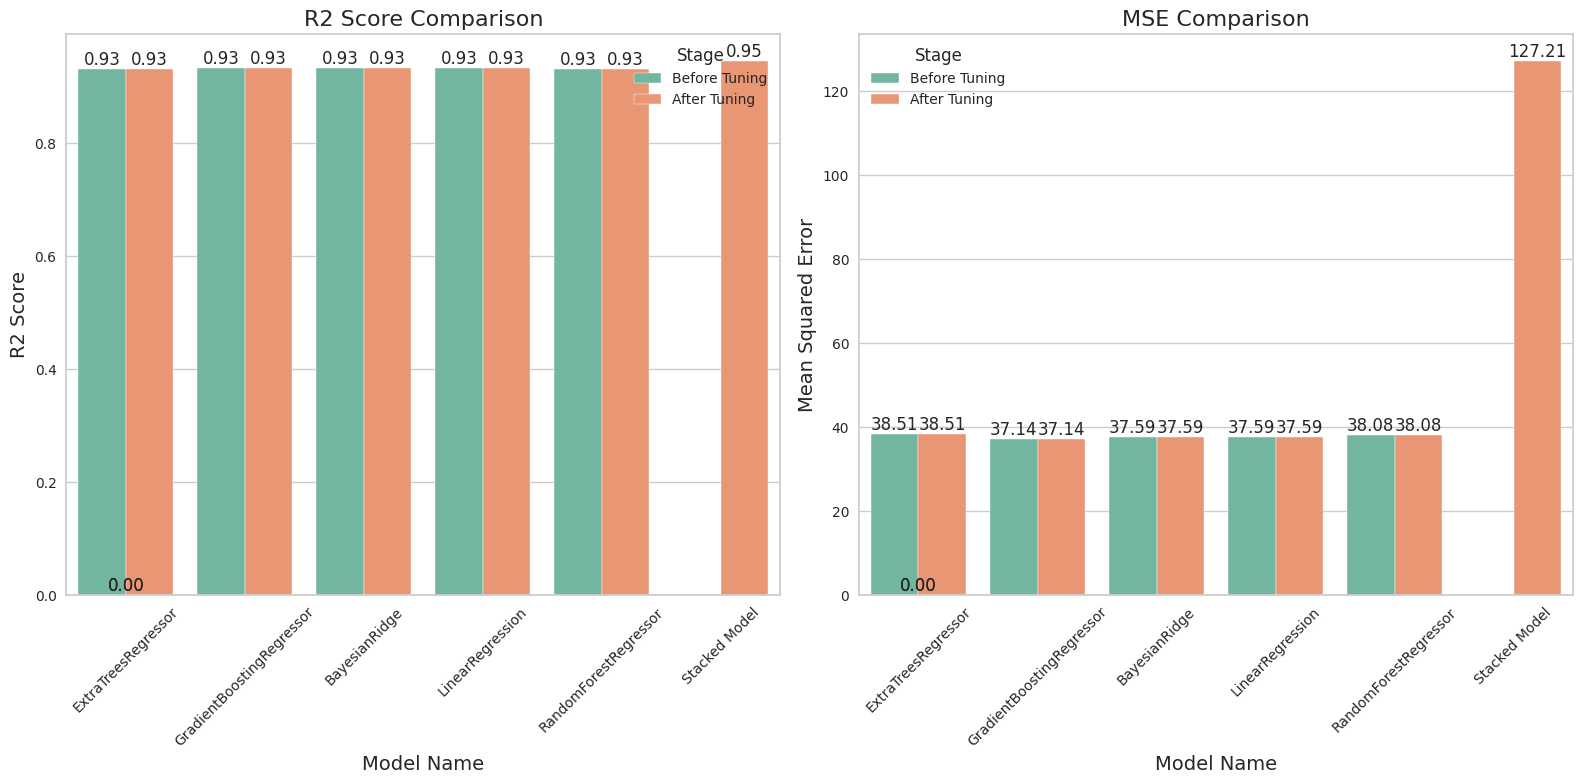


Model Evaluation Results Before Tuning:
Model Name                     R2 Score        MSE            
------------------------------------------------------------
ExtraTreesRegressor            0.9309          38.5060        
GradientBoostingRegressor      0.9333          37.1374        
BayesianRidge                  0.9325          37.5876        
LinearRegression               0.9325          37.5920        
RandomForestRegressor          0.9317          38.0793        

Model Evaluation Results After Tuning:
Model Name                     R2 Score        MSE            
------------------------------------------------------------
ExtraTreesRegressor            0.9309          38.5060        
GradientBoostingRegressor      0.9333          37.1374        
BayesianRidge                  0.9325          37.5876        
LinearRegression               0.9325          37.5920        
RandomForestRegressor          0.9317          38.0793        
Stacked Model                  0.9451    

In [11]:
predictor.display_results()

# 확인할 수 있는 인사이트
## 1. No Scaling, MinMax Scaling, Standard Scaling 중 MinMax Scaling을 통한 ML이 가장 좋게 나온다.
    - 우리 data에 적합한 scaling은 MinMaxScaler
## 2. Hyperparameter Tuning을 해봤자 default로 돌린 게 제일 잘 나온다.
    - data 자체가 많지 않고 task가 복잡한 편이 아님
## 3. 일부 regressor를 제외하면 대부분이 비슷한 성능이 나옴.
    - Model 자체로 성능을 올리기 보단 더 많은 데이터 혹은 학습기법을 통한 성능 향상이 필요해보임 ex. Stacking Ensemble